In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'dermamnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 100
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
from torch.utils.data import DataLoader

# Augmentation for the training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Rotate images by ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0)),  # Random crop with scaling
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# No augmentation for validation & test sets (only normalization)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets with appropriate transformations
train_dataset = DataClass(split='train', transform=train_transform, download=download)
validation_dataset = DataClass(split='val', transform=test_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 7007
Validation samples: 1003
Test samples: 2005


In [5]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoints: 7007
    Root location: /home/oussama/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST of size 28 (dermamnist)
    Number of datapoi

In [6]:
# visualization

train_dataset.montage(length=1)

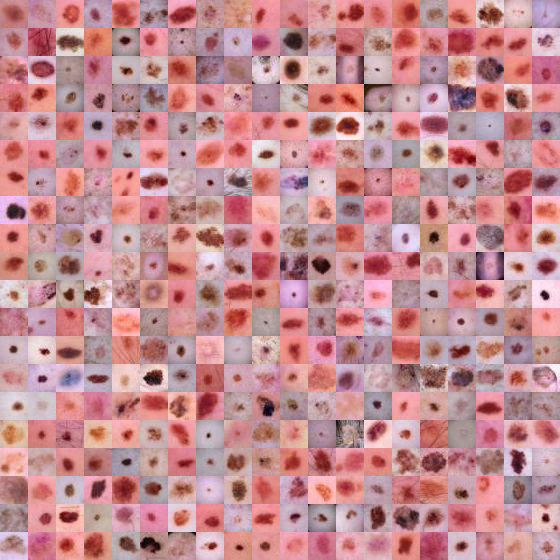

In [7]:
# montage

train_dataset.montage(length=20)

In [8]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [9]:
class M5(torch.nn.Module):
    def __init__(self, output=9):
        super(M5, self).__init__()
        # Layer 1
        self.Conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.ReLU1 = nn.ReLU()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 2
        self.Conv2 = torch.nn.Conv2d(in_channels=16, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.ReLU2 = nn.ReLU()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size = 2)
        # Layer 3
        self.Conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.ReLU3 = nn.ReLU()
        self.AvgPool3 = torch.nn.AvgPool2d(kernel_size = 3)
        self.Flatten = nn.ReLU()
        self.FC1 = torch.nn.Linear(1*1*128, output)


    def forward(self, x):
        out = self.Conv1(x)
        out = self.ReLU1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.ReLU2(out)
        out = self.AvgPool2(out)
        out = self.Conv3(out)
        out = self.ReLU3(out)
        out = self.AvgPool3(out)
        out = self.Flatten(out)
        out = out.view(out.shape[0], -1)  # Fix flattening
        out = self.FC1(out)
        return out
    
model = M5(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [31]:
class Square(torch.nn.Module):
    def forward(self, x):
        return x**2
    
class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

def _approximated_ReLU(x):
    return 0.117071 * x**2 + 0.5 * x + 0.375373

class ApproxReLU(torch.nn.Module):
    def forward(self, x):
        return _approximated_ReLU(x)
    

In [11]:
class M4(torch.nn.Module):
    def __init__(self, hidden=84, output=10):
        super(M4, self).__init__()
        self.Conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.Square1 = nn.ReLU()
        self.AvgPool1 = torch.nn.AvgPool2d(kernel_size = 2)
        self.Conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.Square2 = nn.ReLU()
        self.AvgPool2 = torch.nn.AvgPool2d(kernel_size = 2)
        self.Conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1, padding=0)
        self.Square3 = nn.ReLU()
        self.Flatten = Flatten()
        self.FC1 = torch.nn.Linear(120, hidden)
        self.Square4 = nn.ReLU()
        self.FC2 = torch.nn.Linear(hidden, output)

    def forward(self, x):
        out = self.Conv1(x)
        out = self.Square1(out)
        out = self.AvgPool1(out)
        out = self.Conv2(out)
        out = self.Square2(out)
        out = self.AvgPool2(out)
        out = self.Conv3(out)
        out = self.Square3(out)
        out = self.Flatten(out)
        out = self.FC1(out)
        out = self.Square4(out)
        out = self.FC2(out)
        return out
    
model = M4(output=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [12]:
class M8(nn.Module):
    def __init__(self, outputs=2):
        super(M8, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2)  # Reduce feature map size

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size=2)  # ADDED: Extra pooling layer

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=400, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.conv3(output)
        output = self.relu3(output)

        output = self.Flatten(output)

        output = self.fc(output)
        return output
    
model = M8(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [13]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [17]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [35]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


100%|██████████| 55/55 [00:04<00:00, 12.28it/s]



Summary: Train Loss: 1.8756, Train Acc: 42.50%, Validation Loss: 0.8460, Validation Acc: 66.90%

Epoch [2/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.10it/s]



Summary: Train Loss: 1.4313, Train Acc: 66.98%, Validation Loss: 0.5954, Validation Acc: 66.90%

Epoch [3/100] Training...


100%|██████████| 55/55 [00:04<00:00, 12.37it/s]



Summary: Train Loss: 1.1649, Train Acc: 66.98%, Validation Loss: 0.5690, Validation Acc: 66.90%

Epoch [4/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.57it/s]



Summary: Train Loss: 1.1232, Train Acc: 66.98%, Validation Loss: 0.5548, Validation Acc: 66.90%

Epoch [5/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.36it/s]



Summary: Train Loss: 1.1037, Train Acc: 66.98%, Validation Loss: 0.5478, Validation Acc: 66.90%

Epoch [6/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.43it/s]



Summary: Train Loss: 1.0911, Train Acc: 66.98%, Validation Loss: 0.5424, Validation Acc: 66.90%

Epoch [7/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.33it/s]



Summary: Train Loss: 1.0858, Train Acc: 66.98%, Validation Loss: 0.5392, Validation Acc: 66.90%

Epoch [8/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.00it/s]



Summary: Train Loss: 1.0794, Train Acc: 66.98%, Validation Loss: 0.5366, Validation Acc: 66.90%

Epoch [9/100] Training...


100%|██████████| 55/55 [00:03<00:00, 13.95it/s]



Summary: Train Loss: 1.0760, Train Acc: 66.98%, Validation Loss: 0.5348, Validation Acc: 66.90%

Epoch [10/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.54it/s]



Summary: Train Loss: 1.0744, Train Acc: 66.98%, Validation Loss: 0.5328, Validation Acc: 66.90%

Epoch [11/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.50it/s]



Summary: Train Loss: 1.0716, Train Acc: 66.98%, Validation Loss: 0.5305, Validation Acc: 66.90%

Epoch [12/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.45it/s]



Summary: Train Loss: 1.0687, Train Acc: 66.98%, Validation Loss: 0.5294, Validation Acc: 66.90%

Epoch [13/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.60it/s]



Summary: Train Loss: 1.0641, Train Acc: 66.98%, Validation Loss: 0.5266, Validation Acc: 66.90%

Epoch [14/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.05it/s]



Summary: Train Loss: 1.0604, Train Acc: 66.98%, Validation Loss: 0.5247, Validation Acc: 66.90%

Epoch [15/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.55it/s]



Summary: Train Loss: 1.0624, Train Acc: 66.98%, Validation Loss: 0.5235, Validation Acc: 66.90%

Epoch [16/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.65it/s]



Summary: Train Loss: 1.0541, Train Acc: 66.98%, Validation Loss: 0.5225, Validation Acc: 66.90%

Epoch [17/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.63it/s]



Summary: Train Loss: 1.0552, Train Acc: 66.98%, Validation Loss: 0.5202, Validation Acc: 66.90%

Epoch [18/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.59it/s]



Summary: Train Loss: 1.0512, Train Acc: 66.98%, Validation Loss: 0.5180, Validation Acc: 66.90%

Epoch [19/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.56it/s]



Summary: Train Loss: 1.0519, Train Acc: 66.98%, Validation Loss: 0.5167, Validation Acc: 66.90%

Epoch [20/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.48it/s]



Summary: Train Loss: 1.0429, Train Acc: 66.98%, Validation Loss: 0.5144, Validation Acc: 66.90%

Epoch [21/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.67it/s]



Summary: Train Loss: 1.0471, Train Acc: 66.98%, Validation Loss: 0.5123, Validation Acc: 66.90%

Epoch [22/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.31it/s]



Summary: Train Loss: 1.0405, Train Acc: 66.98%, Validation Loss: 0.5110, Validation Acc: 66.90%

Epoch [23/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.60it/s]



Summary: Train Loss: 1.0407, Train Acc: 66.98%, Validation Loss: 0.5093, Validation Acc: 66.90%

Epoch [24/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.41it/s]



Summary: Train Loss: 1.0377, Train Acc: 66.98%, Validation Loss: 0.5065, Validation Acc: 66.90%

Epoch [25/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.27it/s]



Summary: Train Loss: 1.0286, Train Acc: 66.98%, Validation Loss: 0.5041, Validation Acc: 66.90%

Epoch [26/100] Training...


100%|██████████| 55/55 [00:03<00:00, 13.95it/s]



Summary: Train Loss: 1.0303, Train Acc: 66.98%, Validation Loss: 0.5022, Validation Acc: 66.90%

Epoch [27/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.58it/s]



Summary: Train Loss: 1.0270, Train Acc: 66.98%, Validation Loss: 0.4986, Validation Acc: 66.90%

Epoch [28/100] Training...


100%|██████████| 55/55 [00:03<00:00, 13.81it/s]



Summary: Train Loss: 1.0204, Train Acc: 66.98%, Validation Loss: 0.4968, Validation Acc: 66.90%

Epoch [29/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.35it/s]



Summary: Train Loss: 1.0186, Train Acc: 66.98%, Validation Loss: 0.4946, Validation Acc: 66.90%

Epoch [30/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.30it/s]



Summary: Train Loss: 1.0118, Train Acc: 66.98%, Validation Loss: 0.4912, Validation Acc: 66.90%

Epoch [31/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.44it/s]



Summary: Train Loss: 1.0137, Train Acc: 66.98%, Validation Loss: 0.4871, Validation Acc: 66.90%

Epoch [32/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.35it/s]



Summary: Train Loss: 1.0077, Train Acc: 66.98%, Validation Loss: 0.4847, Validation Acc: 66.90%

Epoch [33/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.38it/s]



Summary: Train Loss: 1.0027, Train Acc: 67.00%, Validation Loss: 0.4823, Validation Acc: 66.90%

Epoch [34/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.56it/s]



Summary: Train Loss: 0.9963, Train Acc: 66.96%, Validation Loss: 0.4805, Validation Acc: 67.00%

Epoch [35/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.51it/s]



Summary: Train Loss: 0.9964, Train Acc: 66.95%, Validation Loss: 0.4786, Validation Acc: 67.00%

Epoch [36/100] Training...


100%|██████████| 55/55 [00:03<00:00, 13.81it/s]



Summary: Train Loss: 0.9929, Train Acc: 66.99%, Validation Loss: 0.4780, Validation Acc: 67.00%

Epoch [37/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.12it/s]



Summary: Train Loss: 0.9908, Train Acc: 66.90%, Validation Loss: 0.4750, Validation Acc: 67.00%

Epoch [38/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.37it/s]



Summary: Train Loss: 0.9888, Train Acc: 67.03%, Validation Loss: 0.4727, Validation Acc: 67.00%

Epoch [39/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.27it/s]



Summary: Train Loss: 0.9899, Train Acc: 66.99%, Validation Loss: 0.4706, Validation Acc: 67.00%

Epoch [40/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.53it/s]



Summary: Train Loss: 0.9858, Train Acc: 67.00%, Validation Loss: 0.4732, Validation Acc: 67.00%

Epoch [41/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.53it/s]



Summary: Train Loss: 0.9838, Train Acc: 67.09%, Validation Loss: 0.4673, Validation Acc: 67.00%

Epoch [42/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.31it/s]



Summary: Train Loss: 0.9829, Train Acc: 66.98%, Validation Loss: 0.4674, Validation Acc: 66.90%

Epoch [43/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.11it/s]



Summary: Train Loss: 0.9820, Train Acc: 67.02%, Validation Loss: 0.4712, Validation Acc: 66.90%

Epoch [44/100] Training...


100%|██████████| 55/55 [00:04<00:00, 12.50it/s]



Summary: Train Loss: 0.9851, Train Acc: 67.05%, Validation Loss: 0.4659, Validation Acc: 66.90%

Epoch [45/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.83it/s]



Summary: Train Loss: 0.9863, Train Acc: 66.92%, Validation Loss: 0.4662, Validation Acc: 66.90%

Epoch [46/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.74it/s]



Summary: Train Loss: 0.9749, Train Acc: 66.98%, Validation Loss: 0.4712, Validation Acc: 66.90%

Epoch [47/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.15it/s]



Summary: Train Loss: 0.9742, Train Acc: 67.02%, Validation Loss: 0.4648, Validation Acc: 66.90%

Epoch [48/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.08it/s]



Summary: Train Loss: 0.9810, Train Acc: 67.06%, Validation Loss: 0.4649, Validation Acc: 67.00%

Epoch [49/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.28it/s]



Summary: Train Loss: 0.9767, Train Acc: 67.19%, Validation Loss: 0.4649, Validation Acc: 66.90%

Epoch [50/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.13it/s]



Summary: Train Loss: 0.9752, Train Acc: 67.12%, Validation Loss: 0.4622, Validation Acc: 67.00%

Epoch [51/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.13it/s]



Summary: Train Loss: 0.9731, Train Acc: 67.09%, Validation Loss: 0.4601, Validation Acc: 67.10%

Epoch [52/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.09it/s]



Summary: Train Loss: 0.9695, Train Acc: 67.10%, Validation Loss: 0.4598, Validation Acc: 67.10%

Epoch [53/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.14it/s]



Summary: Train Loss: 0.9655, Train Acc: 67.23%, Validation Loss: 0.4604, Validation Acc: 67.00%

Epoch [54/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.06it/s]



Summary: Train Loss: 0.9687, Train Acc: 67.18%, Validation Loss: 0.4625, Validation Acc: 67.10%

Epoch [55/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.07it/s]



Summary: Train Loss: 0.9674, Train Acc: 67.09%, Validation Loss: 0.4600, Validation Acc: 67.10%

Epoch [56/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.72it/s]



Summary: Train Loss: 0.9694, Train Acc: 67.20%, Validation Loss: 0.4573, Validation Acc: 67.30%

Epoch [57/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.09it/s]



Summary: Train Loss: 0.9659, Train Acc: 67.06%, Validation Loss: 0.4576, Validation Acc: 67.20%

Epoch [58/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.06it/s]



Summary: Train Loss: 0.9662, Train Acc: 67.16%, Validation Loss: 0.4573, Validation Acc: 67.10%

Epoch [59/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.10it/s]



Summary: Train Loss: 0.9616, Train Acc: 67.43%, Validation Loss: 0.4549, Validation Acc: 67.30%

Epoch [60/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.14it/s]



Summary: Train Loss: 0.9609, Train Acc: 67.23%, Validation Loss: 0.4539, Validation Acc: 67.70%

Epoch [61/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.15it/s]



Summary: Train Loss: 0.9571, Train Acc: 67.46%, Validation Loss: 0.4546, Validation Acc: 67.60%

Epoch [62/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.13it/s]



Summary: Train Loss: 0.9679, Train Acc: 67.25%, Validation Loss: 0.4522, Validation Acc: 67.70%

Epoch [63/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.23it/s]



Summary: Train Loss: 0.9604, Train Acc: 67.05%, Validation Loss: 0.4554, Validation Acc: 67.30%

Epoch [64/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.34it/s]



Summary: Train Loss: 0.9650, Train Acc: 67.20%, Validation Loss: 0.4508, Validation Acc: 67.90%

Epoch [65/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.28it/s]



Summary: Train Loss: 0.9643, Train Acc: 67.42%, Validation Loss: 0.4533, Validation Acc: 67.50%

Epoch [66/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.04it/s]



Summary: Train Loss: 0.9640, Train Acc: 67.36%, Validation Loss: 0.4541, Validation Acc: 67.50%

Epoch [67/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.93it/s]



Summary: Train Loss: 0.9632, Train Acc: 67.35%, Validation Loss: 0.4529, Validation Acc: 67.50%

Epoch [68/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.77it/s]



Summary: Train Loss: 0.9546, Train Acc: 67.56%, Validation Loss: 0.4490, Validation Acc: 67.90%

Epoch [69/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.28it/s]



Summary: Train Loss: 0.9527, Train Acc: 67.55%, Validation Loss: 0.4519, Validation Acc: 67.60%

Epoch [70/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.28it/s]



Summary: Train Loss: 0.9599, Train Acc: 67.15%, Validation Loss: 0.4493, Validation Acc: 67.70%

Epoch [71/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.28it/s]



Summary: Train Loss: 0.9587, Train Acc: 67.38%, Validation Loss: 0.4489, Validation Acc: 67.80%

Epoch [72/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.26it/s]



Summary: Train Loss: 0.9555, Train Acc: 67.86%, Validation Loss: 0.4501, Validation Acc: 67.80%

Epoch [73/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.15it/s]



Summary: Train Loss: 0.9465, Train Acc: 67.43%, Validation Loss: 0.4476, Validation Acc: 68.30%

Epoch [74/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.79it/s]



Summary: Train Loss: 0.9457, Train Acc: 67.68%, Validation Loss: 0.4478, Validation Acc: 68.10%

Epoch [75/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.55it/s]



Summary: Train Loss: 0.9492, Train Acc: 67.82%, Validation Loss: 0.4453, Validation Acc: 68.39%

Epoch [76/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.99it/s]



Summary: Train Loss: 0.9562, Train Acc: 67.56%, Validation Loss: 0.4477, Validation Acc: 67.90%

Epoch [77/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.29it/s]



Summary: Train Loss: 0.9522, Train Acc: 67.60%, Validation Loss: 0.4454, Validation Acc: 68.30%

Epoch [78/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.70it/s]



Summary: Train Loss: 0.9503, Train Acc: 67.60%, Validation Loss: 0.4459, Validation Acc: 68.20%

Epoch [79/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.33it/s]



Summary: Train Loss: 0.9429, Train Acc: 67.50%, Validation Loss: 0.4433, Validation Acc: 68.39%

Epoch [80/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.25it/s]



Summary: Train Loss: 0.9481, Train Acc: 67.59%, Validation Loss: 0.4466, Validation Acc: 68.30%

Epoch [81/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.23it/s]



Summary: Train Loss: 0.9434, Train Acc: 67.65%, Validation Loss: 0.4478, Validation Acc: 68.20%

Epoch [82/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.34it/s]



Summary: Train Loss: 0.9395, Train Acc: 67.95%, Validation Loss: 0.4427, Validation Acc: 68.59%

Epoch [83/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.15it/s]



Summary: Train Loss: 0.9467, Train Acc: 68.03%, Validation Loss: 0.4430, Validation Acc: 68.30%

Epoch [84/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.26it/s]



Summary: Train Loss: 0.9452, Train Acc: 67.68%, Validation Loss: 0.4403, Validation Acc: 68.59%

Epoch [85/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.29it/s]



Summary: Train Loss: 0.9472, Train Acc: 68.00%, Validation Loss: 0.4432, Validation Acc: 68.20%

Epoch [86/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.26it/s]



Summary: Train Loss: 0.9461, Train Acc: 67.86%, Validation Loss: 0.4402, Validation Acc: 68.30%

Epoch [87/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.94it/s]



Summary: Train Loss: 0.9364, Train Acc: 67.68%, Validation Loss: 0.4435, Validation Acc: 68.39%

Epoch [88/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.89it/s]



Summary: Train Loss: 0.9448, Train Acc: 67.87%, Validation Loss: 0.4391, Validation Acc: 68.10%

Epoch [89/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.05it/s]



Summary: Train Loss: 0.9426, Train Acc: 67.78%, Validation Loss: 0.4401, Validation Acc: 68.10%

Epoch [90/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.28it/s]



Summary: Train Loss: 0.9384, Train Acc: 67.80%, Validation Loss: 0.4412, Validation Acc: 68.20%

Epoch [91/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.83it/s]



Summary: Train Loss: 0.9403, Train Acc: 68.15%, Validation Loss: 0.4383, Validation Acc: 68.10%

Epoch [92/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.40it/s]



Summary: Train Loss: 0.9387, Train Acc: 67.85%, Validation Loss: 0.4377, Validation Acc: 68.39%

Epoch [93/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.44it/s]



Summary: Train Loss: 0.9406, Train Acc: 67.85%, Validation Loss: 0.4415, Validation Acc: 68.20%

Epoch [94/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.33it/s]



Summary: Train Loss: 0.9336, Train Acc: 68.06%, Validation Loss: 0.4379, Validation Acc: 68.30%

Epoch [95/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.36it/s]



Summary: Train Loss: 0.9338, Train Acc: 68.05%, Validation Loss: 0.4384, Validation Acc: 68.10%

Epoch [96/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.29it/s]



Summary: Train Loss: 0.9338, Train Acc: 67.92%, Validation Loss: 0.4376, Validation Acc: 67.90%

Epoch [97/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.02it/s]



Summary: Train Loss: 0.9350, Train Acc: 68.00%, Validation Loss: 0.4359, Validation Acc: 68.20%

Epoch [98/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.02it/s]



Summary: Train Loss: 0.9366, Train Acc: 67.86%, Validation Loss: 0.4336, Validation Acc: 68.69%

Epoch [99/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.14it/s]



Summary: Train Loss: 0.9287, Train Acc: 67.83%, Validation Loss: 0.4343, Validation Acc: 68.69%

Epoch [100/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.21it/s]



Summary: Train Loss: 0.9395, Train Acc: 67.83%, Validation Loss: 0.4336, Validation Acc: 68.20%


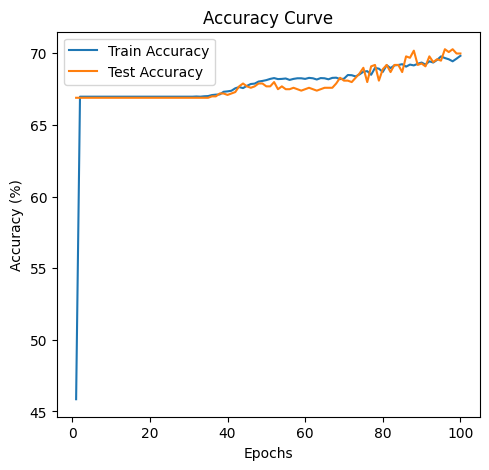

In [81]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [36]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 0.8680, Accuracy: 68.38%


In [84]:
# Save the trained model
MODEL_PATH = "dermato_model.pth"
torch.save(model, MODEL_PATH)

print(f"Model saved successfully as {MODEL_PATH}!")

Model saved successfully as dermato_model.pth!


In [47]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Store attributes
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        # self.bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.relu1 = ApproxReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        # self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                # nn.BatchNorm2d(out_channels)
            )

        self.relu2 = ApproxReLU()

    def forward(self, x):
        identity = x

        # Main path
        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu1(out)

        out = self.conv2(out)
        # out = self.bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu2(out)
        
        return out

In [48]:
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)  # Normalize activations
        self.relu1 = ApproxReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        # Second convolutional layer
        # self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        # self.relu2 = nn.ReLU()
        self.res1 = ResidualBlock(in_channels=6, out_channels=16, stride=1)
        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        # output = self.conv2(output)
        # output = self.relu2(output)
        output = self.res1(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [49]:
# train

for epoch in range(10):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/100] Training...


100%|██████████| 55/55 [00:04<00:00, 12.40it/s]



Summary: Train Loss: 1.4361, Train Acc: 57.26%, Validation Loss: 0.5728, Validation Acc: 66.90%

Epoch [2/100] Training...


100%|██████████| 55/55 [00:04<00:00, 13.66it/s]



Summary: Train Loss: 1.1173, Train Acc: 66.98%, Validation Loss: 0.5445, Validation Acc: 66.90%

Epoch [3/100] Training...


100%|██████████| 55/55 [00:03<00:00, 13.96it/s]



Summary: Train Loss: 1.0891, Train Acc: 66.98%, Validation Loss: 0.5355, Validation Acc: 66.90%

Epoch [4/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.90it/s]



Summary: Train Loss: 1.0729, Train Acc: 66.98%, Validation Loss: 0.5294, Validation Acc: 66.90%

Epoch [5/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.99it/s]



Summary: Train Loss: 1.0655, Train Acc: 66.98%, Validation Loss: 0.5262, Validation Acc: 66.90%

Epoch [6/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.01it/s]



Summary: Train Loss: 1.0601, Train Acc: 66.98%, Validation Loss: 0.5208, Validation Acc: 66.90%

Epoch [7/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.00it/s]



Summary: Train Loss: 1.0546, Train Acc: 66.98%, Validation Loss: 0.5178, Validation Acc: 66.90%

Epoch [8/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.11it/s]



Summary: Train Loss: 1.0496, Train Acc: 66.98%, Validation Loss: 0.5160, Validation Acc: 66.90%

Epoch [9/100] Training...


100%|██████████| 55/55 [00:03<00:00, 14.84it/s]



Summary: Train Loss: 1.0430, Train Acc: 66.98%, Validation Loss: 0.5123, Validation Acc: 66.90%

Epoch [10/100] Training...


100%|██████████| 55/55 [00:03<00:00, 15.04it/s]



Summary: Train Loss: 1.0436, Train Acc: 66.98%, Validation Loss: 0.5090, Validation Acc: 66.90%


In [50]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 1.0096, Accuracy: 66.88%


In [ ]:
# Save the trained model
MODEL_PATH = "../models/dermato_model.pth"
torch.save(model, MODEL_PATH)

print(f"Model saved successfully as {MODEL_PATH}!")


Model saved successfully as ../models/oussama.pth!


In [54]:
# Loop through the model to find ResidualBlock layers
for layer_name, layer in model.named_children():
    
    if isinstance(layer, ResidualBlock):  # Check if layer is ResidualBlock
        
        print(f"Found ResidualBlock: {layer_name}")
        print(f"the output channels :{layer.out_channels}")
        # Loop through the submodules inside the ResidualBlock
        for sub_layer_name, sub_layer in layer.named_children():
            
            if isinstance(sub_layer, nn.Conv2d):
                print("convolution")


            if isinstance(sub_layer, ApproxReLU):
                print(isinstance(sub_layer, ApproxReLU))
                print("relu")
              
            if sub_layer_name == 'downsample' :
                print('downsampling') 
                for sub_sub_layer in sub_layer:
                    if isinstance(sub_sub_layer, nn.Conv2d):
                        print("convolution")

                    if isinstance(sub_sub_layer, ApproxReLU):
                        print("relu")
                
            print(f"  - {sub_layer_name}: {sub_layer}")

Found ResidualBlock: res1
the output channels :16
convolution
  - conv1: Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
True
relu
  - relu1: ApproxReLU()
convolution
  - conv2: Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
downsampling
convolution
  - downsample: Sequential(
  (0): Conv2d(6, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
True
relu
  - relu2: ApproxReLU()


In [23]:
for layer_name, layer in model.named_children():
    layer_params = getattr(model, layer_name)
    if layer.__class__.__name__ == 'ResidualBlock':
        print(layer_params.bn1)
        print(f"Layer: {layer_params.bn1}")
        print(f"  Gamma (weight): {layer_params.bn1.weight.data}")
        print(f"  Beta (bias): {layer_params.bn1.bias.data}")
        print(f"  Running Mean: {layer_params.bn1.running_mean}")
        print(f"  Running Variance: {layer_params.bn1.running_var}\n")
        print('num_features: ', layer_params.bn1.num_features)

BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Layer: BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  Gamma (weight): tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
  Beta (bias): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
  Running Mean: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
  Running Variance: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')

num_features:  16
